# Going Deeper 01
## 프로젝트: ResNet Ablation Study
### 프로젝트 구성
1. ResNet 기본 블록 구성하기
2. ResNet-34, ResNet-50 Complete Model
3. 일반 네트워크(plain network) 만들기
4. ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34


### 프로젝트 평가 기준
| |평가문항|상세기준|
|------|---|---|
|1|ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?|블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.
|2|구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?|cats_vs_dogs 데이터셋으로 학습시 몇 epoch동안 안정적으로 loss 감소가 진행 확인되었다.|
|3| Ablation Study 결과가 바른 포맷으로 제출되었는가?|ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.|

In [1]:
# TensorFLow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
# Tensorflow가 활용할 GPU가 있는지 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. ResNet 기본 블록 구성하기

In [35]:
# function for building cnn Block

def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [36]:
# function for building ResNet Block

def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

# 2. ResNet-34, ResNet-50 Complete Model

In [37]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    assert len(num_cnn_list) == len(channel_list) 
    
    # input layer 생성
    input_layer = keras.layers.Input(shape=input_shape)  
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## ResNet 34

In [38]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_474 (Conv2D)             (None, 16, 16, 64)   9472        input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_474 (BatchN (None, 16, 16, 64)   256         conv2d_474[0][0]                 
__________________________________________________________________________________________________
activation_443 (Activation)     (None, 16, 16, 64)   0           batch_normalization_474[0][0]    
__________________________________________________________________________________________

## ResNet 50

In [39]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_510 (Conv2D)             (None, 16, 16, 64)   9472        input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_510 (BatchN (None, 16, 16, 64)   256         conv2d_510[0][0]                 
__________________________________________________________________________________________________
activation_476 (Activation)     (None, 16, 16, 64)   0           batch_normalization_510[0][0]    
__________________________________________________________________________________________

# 3. 일반 네트워크(plain network) 만들기

In [40]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [41]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## PlainNet 34

In [42]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_563 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_563 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_525 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_564 (Conv2D)          (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_564 (Bat (None, 56, 56, 64)        256

## PlainNet 50

In [43]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_596 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_596 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_558 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_597 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_597 (Bat (None, 56, 56, 64)        256

# Dataset

In [44]:
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [45]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [46]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


# Dataset 확인

In [47]:
# 카테고리 개수 확인
ds_info.features["label"].num_classes

2

In [48]:
# 카테고리 이름 확인
ds_info.features["label"].names

['cat', 'dog']

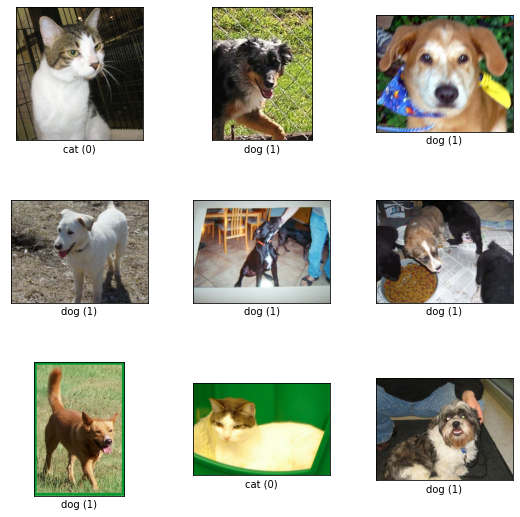

In [49]:
# train image sample 확인
fig=tfds.show_examples(ds_train, ds_info)

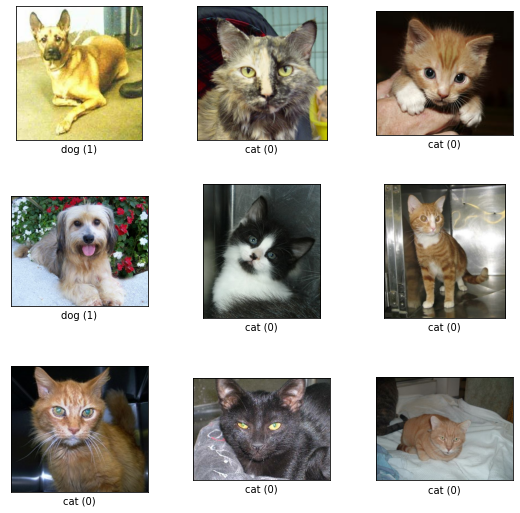

In [50]:
# test image sample 확인
fig=tfds.show_examples(ds_test,ds_info)

# Input Normalization

In [51]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [52]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 4. ResNet, Plain 비교

In [53]:
BATCH_SIZE = 64
EPOCH = 15

In [54]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [55]:
model_resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

model_resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = model_resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
290/290 [==============================] - 224s 613ms/step - loss: 5.8805 - accuracy: 0.5996 - val_loss: 4.4555 - val_accuracy: 0.6769
Epoch 2/15
290/290 [==============================] - 158s 547ms/step - loss: 3.9731 - accuracy: 0.6991 - val_loss: 3.0056 - val_accuracy: 0.6931
Epoch 3/15
290/290 [==============================] - 147s 507ms/step - loss: 2.7067 - accuracy: 0.7601 - val_loss: 2.7214 - val_accuracy: 0.5648
Epoch 4/15
290/290 [==============================] - 147s 508ms/step - loss: 2.0092 - accuracy: 0.7827 - val_loss: 1.9885 - val_accuracy: 0.6966
Epoch 5/15
290/290 [==============================] - 147s 508ms/step - loss: 1.5471 - accuracy: 0.8275 - val_loss: 1.8575 - val_accuracy: 0.5760
Epoch 6/15
290/290 [==============================] - 147s 508ms/step - loss: 1.2412 - accuracy: 0.8561 - val_loss: 1.4908 - val_accuracy: 0.7306
Epoch 7/15
290/290 [==============================] - 147s 508ms/step - loss: 1.0709 - accuracy: 0.8740 - val_loss: 1.2544 -

In [57]:
model_resnet_34 = build_resnet(input_shape=(224, 224, 3),                                
                               num_classes=1, 
                               is_50=False, 
                               activation='sigmoid', 
                               name='ResNet_34')

model_resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = model_resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True
)

Epoch 1/15
290/290 [==============================] - 235s 749ms/step - loss: 2.4937 - accuracy: 0.5987 - val_loss: 1.9547 - val_accuracy: 0.6037
Epoch 2/15
290/290 [==============================] - 212s 733ms/step - loss: 1.7069 - accuracy: 0.7185 - val_loss: 1.4296 - val_accuracy: 0.6846
Epoch 3/15
290/290 [==============================] - 212s 733ms/step - loss: 1.2017 - accuracy: 0.7903 - val_loss: 1.6196 - val_accuracy: 0.5878
Epoch 4/15
290/290 [==============================] - 212s 733ms/step - loss: 0.8541 - accuracy: 0.8512 - val_loss: 1.9882 - val_accuracy: 0.5286
Epoch 5/15
290/290 [==============================] - 212s 732ms/step - loss: 0.6561 - accuracy: 0.8759 - val_loss: 0.6289 - val_accuracy: 0.8688
Epoch 6/15
290/290 [==============================] - 212s 733ms/step - loss: 0.5430 - accuracy: 0.8963 - val_loss: 19.1824 - val_accuracy: 0.5059
Epoch 7/15
290/290 [==============================] - 213s 734ms/step - loss: 0.4558 - accuracy: 0.9111 - val_loss: 1.2031 

In [56]:
model_plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

model_plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = model_plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
290/290 [==============================] - 251s 770ms/step - loss: 2.0638 - accuracy: 0.5595 - val_loss: 1.6384 - val_accuracy: 0.5089
Epoch 2/15
290/290 [==============================] - 204s 702ms/step - loss: 1.3181 - accuracy: 0.6089 - val_loss: 1.1338 - val_accuracy: 0.5894
Epoch 3/15
290/290 [==============================] - 204s 703ms/step - loss: 1.0734 - accuracy: 0.6215 - val_loss: 5.9574 - val_accuracy: 0.4486
Epoch 4/15
290/290 [==============================] - 203s 702ms/step - loss: 0.9554 - accuracy: 0.6417 - val_loss: 0.9418 - val_accuracy: 0.5785
Epoch 5/15
290/290 [==============================] - 203s 701ms/step - loss: 0.8656 - accuracy: 0.6602 - val_loss: 0.9243 - val_accuracy: 0.5302
Epoch 6/15
290/290 [==============================] - 204s 702ms/step - loss: 0.7874 - accuracy: 0.6982 - val_loss: 0.8419 - val_accuracy: 0.6349
Epoch 7/15
290/290 [==============================] - 204s 703ms/step - loss: 0.7522 - accuracy: 0.6967 - val_loss: 1.6956 -

In [58]:
model_plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

model_plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = model_plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
290/290 [==============================] - 398s 1s/step - loss: 4.7148 - accuracy: 0.5045 - val_loss: 3.3354 - val_accuracy: 0.5105
Epoch 2/15
290/290 [==============================] - 332s 1s/step - loss: 2.8958 - accuracy: 0.5111 - val_loss: 2.3957 - val_accuracy: 0.4941
Epoch 3/15
290/290 [==============================] - 332s 1s/step - loss: 2.2423 - accuracy: 0.5669 - val_loss: 1.9611 - val_accuracy: 0.4954
Epoch 4/15
290/290 [==============================] - 332s 1s/step - loss: 1.8762 - accuracy: 0.5912 - val_loss: 23.6799 - val_accuracy: 0.5102
Epoch 5/15
290/290 [==============================] - 331s 1s/step - loss: 1.6847 - accuracy: 0.5102 - val_loss: 1.7501 - val_accuracy: 0.4915
Epoch 6/15
290/290 [==============================] - 331s 1s/step - loss: 1.5224 - accuracy: 0.5190 - val_loss: 1.4261 - val_accuracy: 0.5087
Epoch 7/15
290/290 [==============================] - 331s 1s/step - loss: 1.4122 - accuracy: 0.4990 - val_loss: 1.3539 - val_accuracy: 0.488

## 4-1) ResNet-50 vs Plain-50

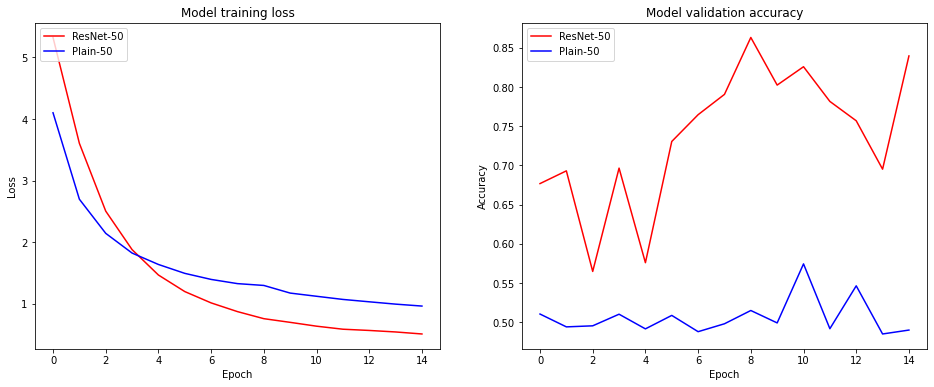

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_resnet_50.history['loss'],'r')
plt.plot(history_plain_50.history['loss'],'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

## 4-2) ResNet-34 vs Plain-34

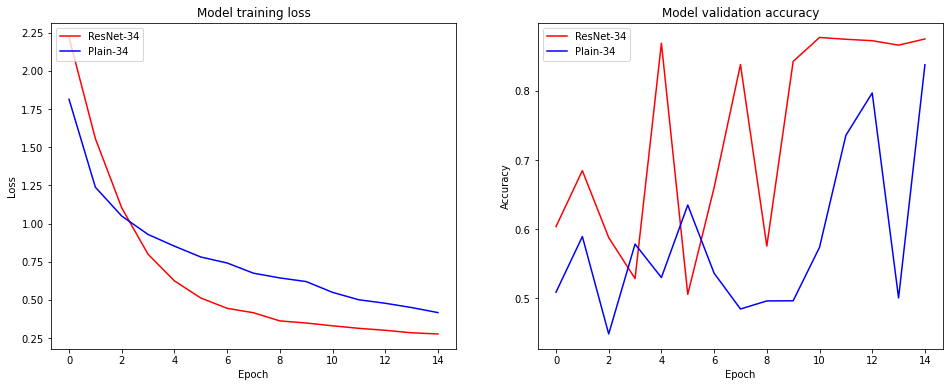

In [66]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_resnet_34.history['loss'],'r')
plt.plot(history_plain_34.history['loss'],'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

# 프로젝트 정리

1. Resnet과 Plain model을 비교했을 때, Resnet-50, Resnet-34가 더 좋은 성능을 보여주고 있습니다.
2. 적절한 epoch는 40 이상을 추천하였지만 학습 시간 때문에 15 epoch만 학습 시켰는데, 더 많이 학습을 시킬 경우 더 좋은 성능 향상 효과를 볼 수 있을 것이라 기대합니다.
3. 메모리 부족 문제로 커널 죽음 문제가 자꾸 발생해서 BATCH_SIZE를 줄여서 해결하였습니다.

카이밍 허가 2015년 발표한 [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)의 논문은 layer를 더 깊게 쌓으면 이론적으로는 error가 떨어져야 하는데, Vanishing/Exploding Gradient 등의 문제 등을 해결하여도 성능이 더 떨어지는 경우를 지적하며  ResNet을 발표했습니다.

overfitting 때문이 아닌 네트워크 구조상 layer를 깊이 쌓았을 때 optimization(최적화)가 잘 안되기 때문에 발생하는 문제 임을 지적했고, 깊은 네트워크를 학습시키기 위한 방법으로 residual learning(잔여 학습)을 제안하였습니다. residual block을 이용하여 네트워크를 optimization을 낮추었고, 해당 프로젝트는 논문에서 제안한 모델을 직접 구현해보는 과정이었습니다.